In [1]:
import sys
sys.path.append('..')
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

from tqdm import tqdm
from sqlalchemy import func
import webbrowser
import seaborn as sns
from matplotlib import ticker
from wordcloud import WordCloud
from collections import Counter


from src.pingers import *
from src.models import *
from src import crud
from src.utils import *
from src.models.enums import CreativeType, TextType, Target
from src.fb_api.get_preview_shareable_link import get_preview_shareable_link
from src.statistical_tests import mean_test


from src.database.session import db
metrics = (cr, ctr, cpm, roas)
df_path = '/app/data/last_6_months.csv'

end_date = date.today()
start_date = end_date - relativedelta(months=12)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

2023-10-19 07:58:24.421 | DEBUG    | src.database.session:<module>:17 - base: prod.cw6tznt1p9hq.us-east-1.rds.amazonaws.com


In [44]:
b = 'b'
a = lambda x: b + 'x'
b = 'f'
a('c')

'fx'

In [41]:
metrics = (cr, cpm)
metric_format_dict = {str(metric): lambda x, pos: metric.format(x) for metric in metrics}
metric_format_dict[str(cr)](5, _)

'$5'

In [42]:
metric

In [2]:
from_scratch = False
if not os.path.exists(df_path) or from_scratch:
    query = db.query(FacebookDailyPerformance.ad_id).filter(
        FacebookDailyPerformance.date_start.between(start_date, end_date),
    ).group_by(FacebookDailyPerformance.ad_id).having(func.sum(FacebookDailyPerformance.spend) > 1000)
    ad_ids_df = read_query_into_df(db=db, query=query, chunk_size=20000)
    ad_ids = ad_ids_df.ad_id.tolist()
    df = ping_facebook_creative_target_and_performance(
        db=db, ad_id=ad_ids, start_date=start_date, end_date=end_date, period=Period.year_month
    )
    df = df[df.spend_USD > 500]

    df = df[df.countries.apply(lambda l: len(l)) == 1]
    df = df[df.countries.apply(lambda l: l[0]) == 'US']

    for metric in metrics:
        df[str(metric)] = df.apply(metric.formula_series, axis=1)

    #broken conversion
    df = df[df.CR.apply(lambda x: x in cr.interval)&df.CTR.apply(lambda x: x in ctr.interval)]
    # df = df[df.ROAS.between(100, 7000)]
    df = df[df.creative_type != CreativeType.unknown]
    df = df.applymap(convert_enum_to_its_value)
    df.to_csv(df_path, index=False)
df = read_csv_and_eval(df_path)
df = df[df.target.notna()]
df.year_month = df.year_month.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.target = df.target.apply(Target)
df = df[df.purch_value_USD > 1000]
len(df)

9850

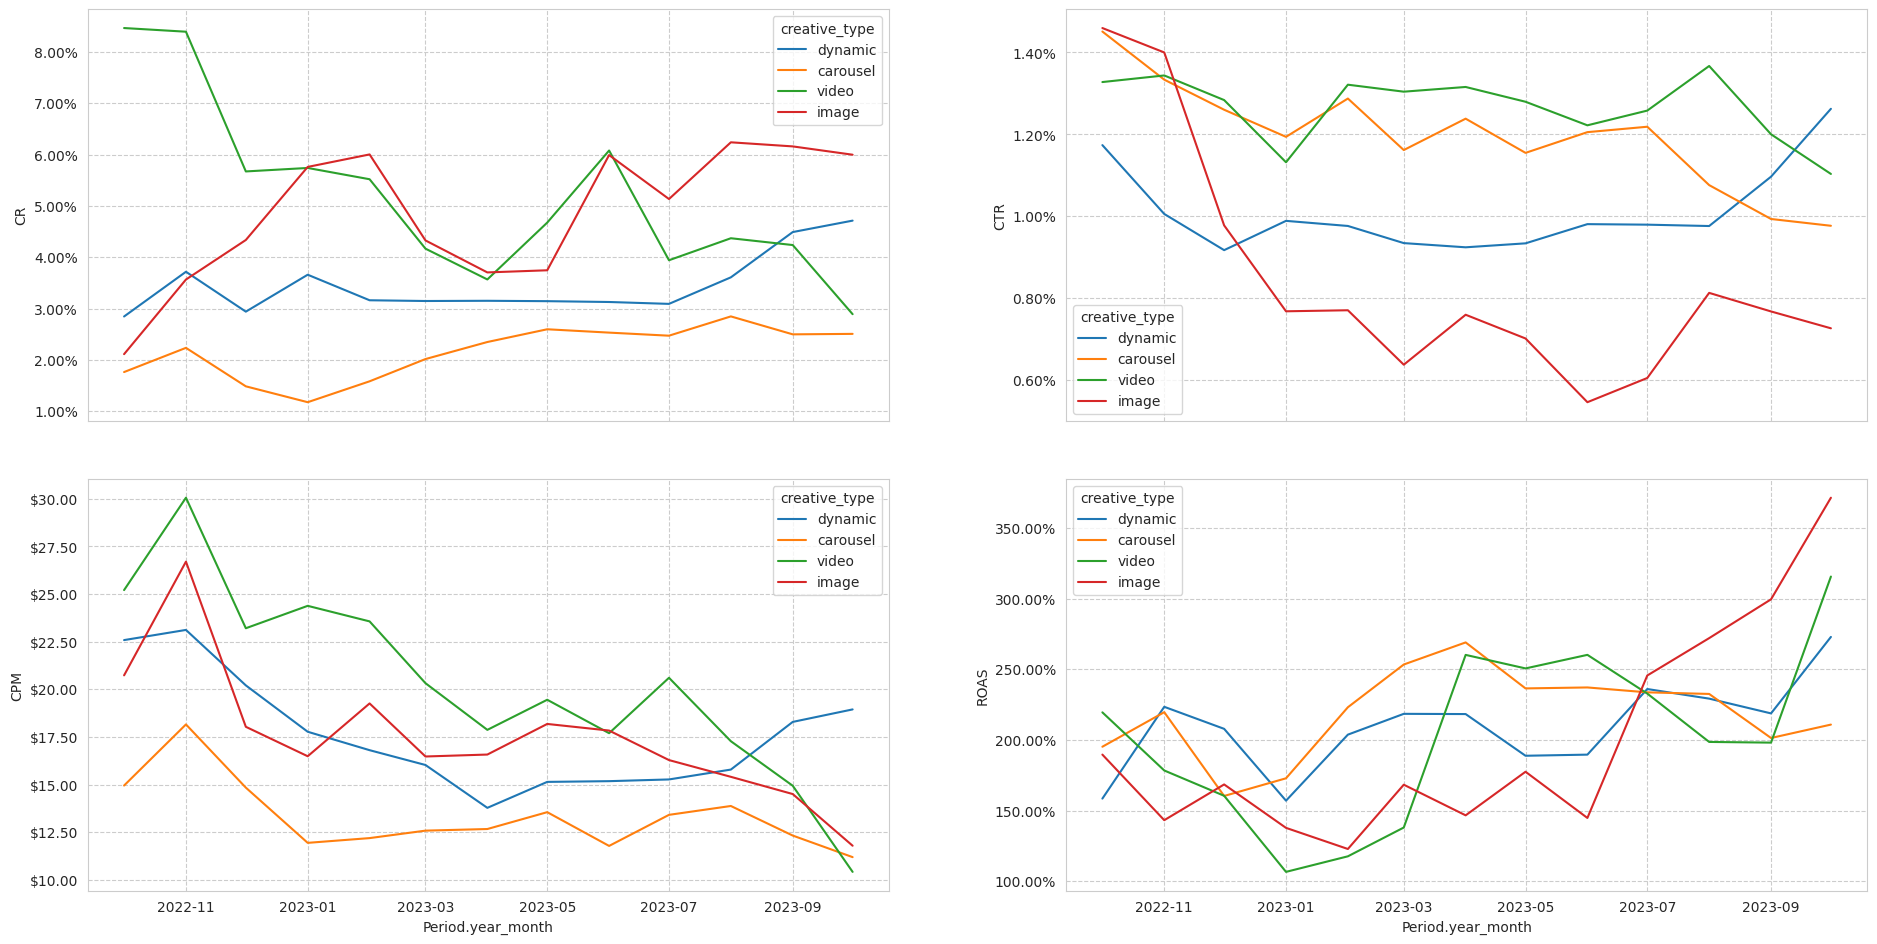

In [14]:
plot_df = df[df.target == Target.acquisition]
plot_df = df
metrics = (cr, ctr, cpm, roas)
fig, axs = plt.subplots(2, int(np.ceil(len(metrics)/2)), sharex=True)
fig.tight_layout(pad=1)
fig.set_figheight(10)
fig.set_figwidth(20)

# metric_format_dict = {
#     str(cr): (lambda num, pos: cr.format(num)),
#     str(cpm): (lambda num, pos: cpm.format(num)),
#     str(ctr): (lambda num, pos: ctr.format(num)),
# }
metric_format_dict = {}
for metric in metrics:
    metric_format_dict[str(metric)] = metric.format_ticker

for idx, metric in enumerate(metrics):
    ax = axs[idx//2, idx%2]
    g = sns.lineplot(
        data=plot_df,
        x=Period.year_month,
        y=str(metric),
        hue="creative_type",
        estimator=np.median,
        ax=ax,
        errorbar=None,
    )
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(metric.format_ticker))
    handles, labels = ax.get_legend_handles_labels()


# plt.show()

In [29]:
df.year_month.unique()

<DatetimeArray>
['2023-10-01 00:00:00', '2023-09-01 00:00:00', '2023-07-01 00:00:00',
 '2023-08-01 00:00:00', '2022-10-01 00:00:00', '2022-11-01 00:00:00',
 '2022-12-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00',
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00',
 '2023-01-01 00:00:00']
Length: 13, dtype: datetime64[ns]

In [36]:
str_metrics = [str(metric) for metric in metrics]
filtered_df = df[df.year_month == (df.year_month.max() - relativedelta(month=3))]
filtered_df[str_metrics].mean()

CR        5.346624
CTR       1.342423
CPM      18.774506
ROAS    346.516353
dtype: float64

In [17]:
dynamic_df = plot_df[plot_df.creative_type == CreativeType.dynamic]
mean_df = dynamic_df.groupby('year_month')[['CPM', 'spend_USD', 'impr']].median().reset_index()
mean_df['monthly_cpm'] = mean_df.apply(lambda row: row.spend_USD / row.impr, axis=1) * 1000
# mean_df.applymap(big_number_human_format)
mean_df

,year_month,CPM,spend_USD,impr,monthly_cpm
0,2022-10-01,22.581183,1764.190000,85684.0,20.589492
1,2022-11-01,23.114495,2087.880000,79898.0,26.131818
2,2022-12-01,20.204231,1756.190000,87263.5,20.125138
3,2023-01-01,17.771091,2011.543295,110660.0,18.177691
4,2023-02-01,16.804561,1742.330000,100456.0,17.344210
5,2023-03-01,16.026798,1641.300000,106173.0,15.458732
6,2023-04-01,13.778222,1673.426087,131414.0,12.734002
7,2023-05-01,15.140205,1546.440000,101659.0,15.212032
8,2023-06-01,15.178493,1641.829794,107853.5,15.222777
9,2023-07-01,15.268598,1961.000000,121042.0,16.200988


In [19]:
dynamic_df.loc[dynamic_df.year_month == dynamic_df.year_month.max(), 'CPM'].median()

18.94362337276419

In [14]:
dynamic_df.groupby('year_month')[['spend_USD', 'impr']].sum().applymap(big_number_human_format)

,spend_USD,impr
year_month,,
2022-10-01,665.20K,28.81M
2022-11-01,2.04M,90.92M
2022-12-01,1.60M,80.98M
2023-01-01,1.67M,94.58M
2023-02-01,1.15M,68.72M
2023-03-01,1.51M,101.70M
2023-04-01,1.11M,84.14M
2023-05-01,842.46K,58.62M
2023-06-01,981.14K,68.54M


In [16]:
dynamic_df.year_month.value_counts().sort_index()

year_month
2022-10-01    152
2022-11-01    414
2022-12-01    392
2023-01-01    338
2023-02-01    271
2023-03-01    340
2023-04-01    289
2023-05-01    215
2023-06-01    206
2023-07-01    344
2023-08-01    358
2023-09-01    341
2023-10-01    188
Name: count, dtype: int64

In [108]:
axs[0,0].yaxis

In [96]:
cpm.format(5)

'$5'

In [36]:
df.groupby('creative_type').apply(lambda df: df.shop_id.nunique())

creative_type
carousel    56
dynamic     68
image       28
video       27
dtype: int64

In [37]:
df.creative_type.value_counts()

creative_type
dynamic     385
carousel    236
image       109
video        97
Name: count, dtype: int64

In [38]:
df.shop_id.nunique()

104

In [39]:
len(df)

827

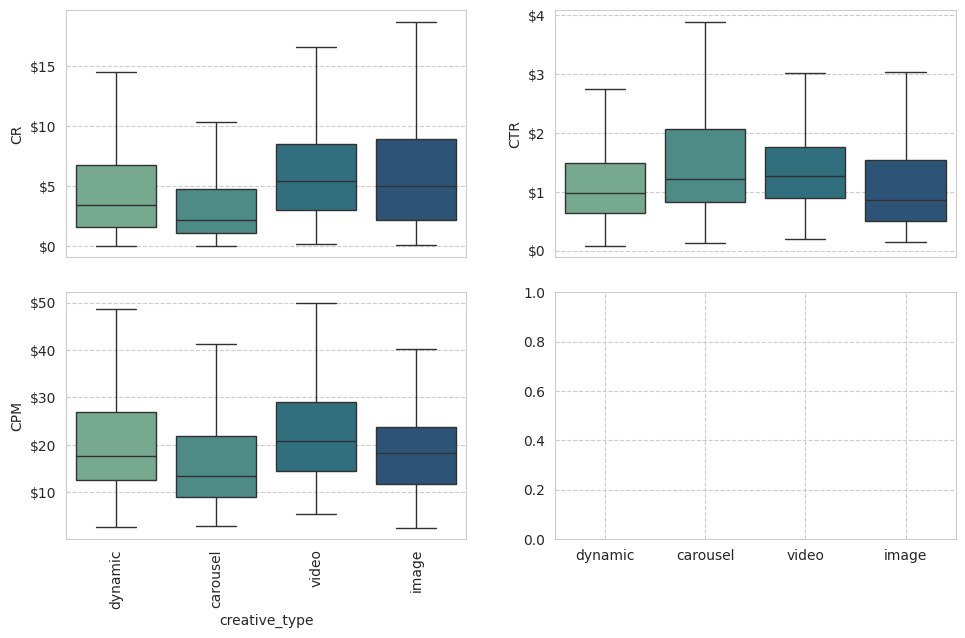

In [29]:
plot_df = df

fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout(pad=1.0)
fig.set_figwidth(10)
fig.set_figheight(6)
for idx, metric in enumerate(metrics):
    ax = axs[idx//2, idx%2]
    g = sns.boxplot(data=df, x='creative_type', hue='creative_type', y=str(metric), palette='crest', showfliers=False, ax=ax)
    g.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: metric.format(x, big_decimals=0)))
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

In [32]:
df = pd.DataFrame(data=[[0, 2], [1, 0], [7, 8]], columns=['prc_col', 'money_col'])

In [82]:
df

,prc_col,money_col
0,0,1
1,1,0


2023-10-19 06:53:19.606 | DEBUG    | __main__:<module>:9 - (0, 0)
2023-10-19 06:53:19.633 | DEBUG    | __main__:<module>:9 - (0, 1)


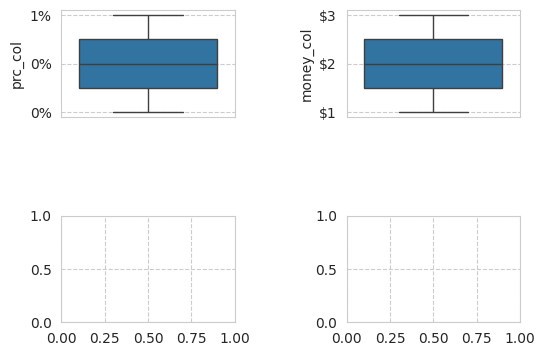

In [3]:
df = pd.DataFrame(data=[[0, 1], [1, 0]], columns=["prc_col", "money_col"])
df2 = pd.DataFrame(data=[[2, 1], [1, 3]], columns=["prc_col", "money_col"])
dfs = [df, df2]
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=5.0)
formatting_dict = {"prc_col": lambda num, pos: f"{round(num)}%", "money_col": lambda num, pos: f"${round(num)}"}

for idx, col in enumerate(df.columns):
    logger.debug((idx//2, idx%2))
    ax = axs[idx//2, idx%2]
    sns.boxplot(data=dfs[idx], y=col, showfliers=False, ax=ax)
for idx, col in enumerate(df.columns):
    ax = axs[idx//2, idx%2]
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatting_dict[col]))

# sns.boxplot(data=df, y="money_col", showfliers=False, ax=axs[0, 0])
# sns.boxplot(data=df, y="prc_col", showfliers=False, ax=axs[0, 1])

# axs[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(formatting_dict["money_col"]))
# axs[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(formatting_dict["prc_col"]))
plt.show()

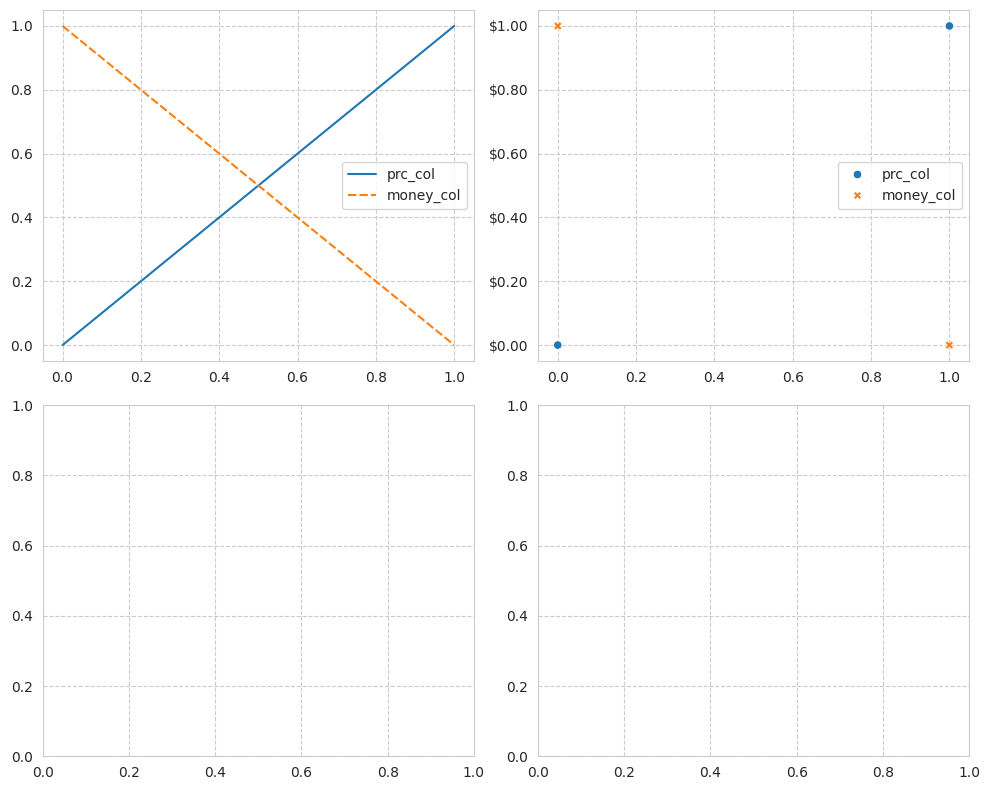

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create your data and subplots as described in the previous answer
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Create and customize the subplots
sns.lineplot(data=df, ax=axes[0, 0])

sns.scatterplot(data=df, ax=axes[0, 1])

# Create different formatters for each subplot
formatter1 = ticker.ScalarFormatter(useOffset=False, useMathText=True)
formatter2 = ticker.FuncFormatter(lambda x, pos: f"${x:.2f}")


# Apply the formatters to the respective y-axes
axes[0, 0].yaxis.set_major_formatter(formatter1)
axes[0, 1].yaxis.set_major_formatter(formatter2)


# Adjust layout to prevent overlapping labels or titles
plt.tight_layout()

# Display the subplots
plt.show()

In [41]:
creative_types = [ct for ct in get_enum_values(CreativeType) if ct not in (CreativeType.unknown, CreativeType.image)]
grouped_df = df.groupby('creative_type')
sample_dict = {ct: grouped_df.get_group(ct)['ROAS'].to_list() for ct in creative_types}

In [42]:
mean_test(samples_dict=sample_dict)

{'stat': 1.822952597191943,
 'p': 0.4019304165133031,
 'test_type': 'kruskal',
 'stat_levene': 0.542599984593804,
 'p_levene': 0.5814742256595419,
 'video': {'mean': 399.70656570842254, 'size': 97},
 'dynamic': {'mean': 371.36442063525726, 'size': 385},
 'carousel': {'mean': 348.83248988130487, 'size': 236}}

In [43]:
mean_test()

TypeError: mean_test() missing 1 required positional argument: 'samples_dict'

In [44]:
big_number_human_format(num=5_000_000, big_decimals=0)

'5M'

In [46]:
top_candidates = df[(df.days_active > 5) & (df.spend_USD > 800) & (df.creative_type != CreativeType.unknown)]
top_candidates = (
    top_candidates.groupby(['shop_id', "creative_type"]).apply(lambda df: df.nlargest(1, "ROAS")).reset_index(drop=True)
).groupby(['creative_type']).apply(lambda df: df.nlargest(6, "ROAS")).reset_index(drop=True)

In [47]:
top_candidates.shop_id.nunique()

19

In [86]:
# adding links
top_candidates = top_candidates[top_candidates.shop_id.isin(access_tokens_dict.keys())]
top_candidates["preview_link"] = top_candidates.apply(
    lambda row: get_preview_shareable_link(ad_id=row.ad_id, access_token=access_tokens_dict[row.shop_id]), axis=1
)
top_candidates.to_csv('/app/data/top_candiates.csv', index=False)
# for link in top_candidates.preview_link:
#     if link is not None and len(link):
#         webbrowser.open(link)

In [8]:
top_discount_candidates = df[(df.days_active > 5) & (df.spend_USD > 800) & (df.creative_type != CreativeType.unknown) & (df.discount)]

In [9]:
hmm = top_discount_candidates.nlargest(50, 'ROAS')
len(hmm[hmm.discount_value <= 50])

44

In [10]:
sns.color_palette('crest')[5]

(0.14573579, 0.29354139, 0.49847009)

/tmp/ipykernel_29733/2002189826.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=df, x='creative_type', y=str(metric), palette='crest', showfliers=False, ax=axs)


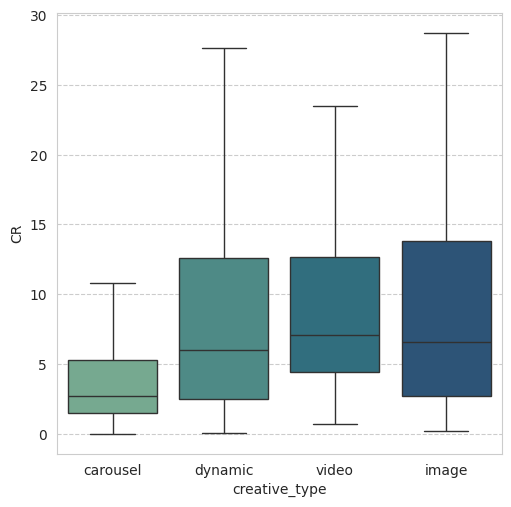

In [11]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
metric = cr
# sns.reset_defaults()
fig, axs = plt.subplots(1, 1, sharex=True)
fig.tight_layout(pad=1.0)
fig.set_figwidth(5)
fig.set_figheight(5)
g = sns.boxplot(data=df, x='creative_type', y=str(metric), palette='crest', showfliers=False, ax=axs)
plt.show()

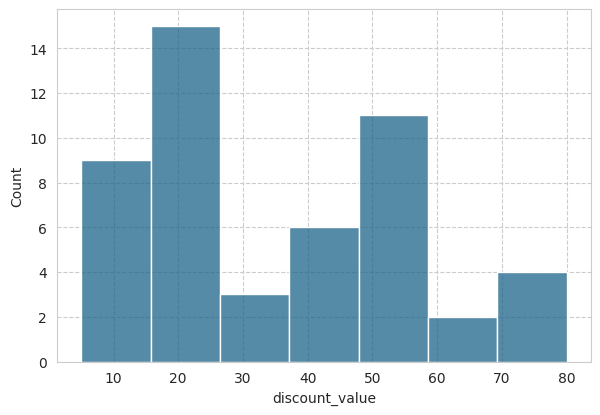

In [12]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axs = plt.subplots(1, 1, sharex=True)
fig.tight_layout(pad=1.0)
fig.set_figwidth(6)
fig.set_figheight(4)
sns.histplot(data=top_discount_candidates.nlargest(50, 'ROAS'), x='discount_value', color=sns.color_palette('crest')[4], ax=axs)
plt.show()
plt.show()

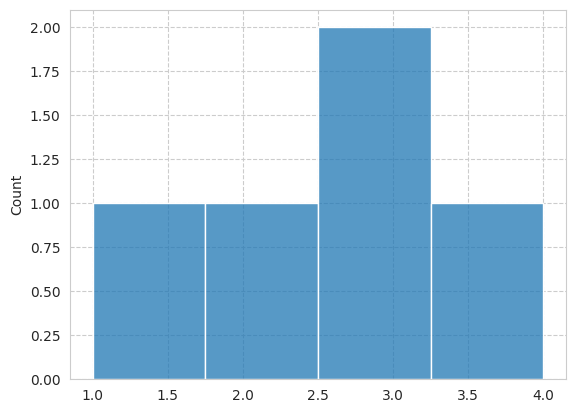

In [85]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(x=[1, 2, 3, 3, 4])
plt.show()

In [64]:
top_candidates

NameError: name 'top_candidates' is not defined

<Axes: >

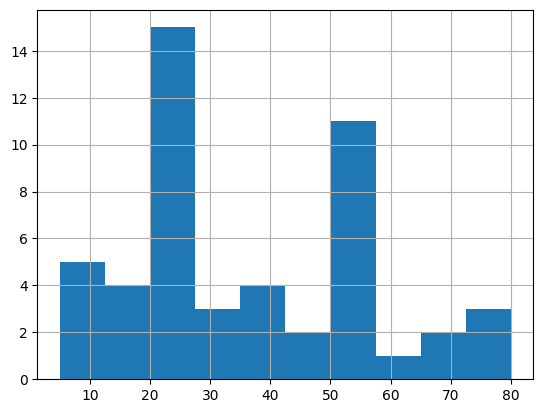

In [55]:
top_discount_candidates.nlargest(50, 'ROAS').discount_value.hist()

In [57]:
top_discount_candidates.creative_type.value_counts() / df.creative_type.value_counts()

creative_type
dynamic     0.220779
carousel    0.194915
image       0.201835
video       0.144330
Name: count, dtype: float64

In [58]:
df.creative_type.value_counts()

creative_type
dynamic     385
carousel    236
image       109
video        97
Name: count, dtype: int64

In [28]:
df.groupby('creative_type').apply(lambda df: df.shop_id.nunique())

creative_type
CreativeType.carousel    52
CreativeType.dynamic     65
CreativeType.image       28
CreativeType.video       27
dtype: int64

In [87]:
link_df = read_csv_and_eval(link_df_path)

In [88]:
creative_type_links_dict = {ct: link_df.loc[link_df.creative_type == ct, 'preview_link'].dropna().tolist() for ct in link_df.creative_type.unique().tolist()}

In [89]:
creative_type_links_dict

{'carousel': ['https://fb.me/1ELl50WuZkRh17v',
  'https://fb.me/1F9zWwVClltpVVl',
  'https://fb.me/22irTsHAZngWvHj',
  'https://fb.me/1MFuMSxMq39RlI2',
  'https://fb.me/1Frdi8tZDr3zOO7'],
 'dynamic': ['https://fb.me/9jDarQxDS3E8pW',
  'https://fb.me/1UrLx4fW3UKV1YP',
  'https://fb.me/1GBkmmFie4IK2b5',
  'https://fb.me/1ZcUcBCIOkTqdUi',
  'https://fb.me/1VVJxIRJqQCJ3Nu'],
 'image': ['https://fb.me/1FRmZrfANkb5yWT',
  'https://fb.me/1NJlwswhVz4Niay',
  'https://fb.me/b0RyExxcDIvVah',
  'https://fb.me/bq8LJLQMoVwSEi'],
 'video': ['https://fb.me/25TrLMIB2ddadly',
  'https://fb.me/1MXqvjk2caFrvNe',
  'https://fb.me/1RdC7nIoRFy0qZb',
  'https://fb.me/1Fhz2iX6dc6vll2',
  'https://fb.me/1R1VPJGoppgSuZa']}

In [90]:
print('\n'.join([ct + '\n' + '\n'.join(creative_type_links_dict[ct]) for ct in creative_type_links_dict.keys()]))

carousel
https://fb.me/1ELl50WuZkRh17v
https://fb.me/1F9zWwVClltpVVl
https://fb.me/22irTsHAZngWvHj
https://fb.me/1MFuMSxMq39RlI2
https://fb.me/1Frdi8tZDr3zOO7
dynamic
https://fb.me/9jDarQxDS3E8pW
https://fb.me/1UrLx4fW3UKV1YP
https://fb.me/1GBkmmFie4IK2b5
https://fb.me/1ZcUcBCIOkTqdUi
https://fb.me/1VVJxIRJqQCJ3Nu
image
https://fb.me/1FRmZrfANkb5yWT
https://fb.me/1NJlwswhVz4Niay
https://fb.me/b0RyExxcDIvVah
https://fb.me/bq8LJLQMoVwSEi
video
https://fb.me/25TrLMIB2ddadly
https://fb.me/1MXqvjk2caFrvNe
https://fb.me/1RdC7nIoRFy0qZb
https://fb.me/1Fhz2iX6dc6vll2
https://fb.me/1R1VPJGoppgSuZa


In [77]:
link_df.shop_id.nunique()

9

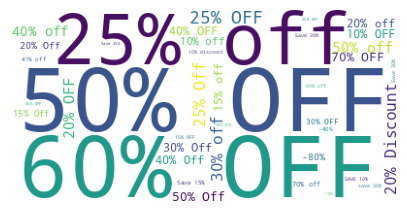

In [57]:
plt.figure(figsize=(5, 5))
discount_text = sum(df[df.discount].discounts.tolist(), [])
wc = WordCloud(background_color='white', stopwords=set('hey'), include_numbers=True).generate_from_frequencies(frequencies=dict(Counter(discount_text)))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [29]:
discount_text

'25% off, 40% Off, 40% OFF, 40% Off, 40% OFF, -80%, -80%, 10% off, 40% Off, 40% off, 15% off, -80%, 20% off, 20% Off, -80%, 50% OFF, 50% OFF, 50% OFF, 50% OFF, 10% Off, Save 20%, 20% Off, 10% off, 10% off, 10% off, 10% off, 10% off, 30% Off, 40% Off, 40% OFF, 40% Off, 40% OFF, 20% off, 20% off, 20% Off, 20% off, -10%, 10% off, 10% OFF, 20% Off, 20% off, -10%, 15% off, 25% off, 65% Off, 65% OFF, 15% off, 15% off, 30% OFF, 50% Off, 50% Off, 30% Off, 50% OFF, 50% OFF, 50% OFF, 50% OFF, 25% Off, 25% Off, 30% Off, 30% Off, 21% off, 40% OFF, 40% OFF, 50% OFF, 50% OFF, 50% off, 50% OFF, 15% off, 20% off, 20% OFF, 70% off, -80%, -80%, 55% OFF, 55% OFF, -80%, -80%, 20% OFF, 10% OFF, SAVE 10%, 10% OFF, SAVE 10%, -80%, 50% off, 50% OFF, 10% OFF, SAVE 10%, 20% OFF, 40% off, -40%, 40% off, -40%, 40% off, -40%, 40% off, -40%, 30% off, 30% off, 15% off, 50% Off, 30% OFF, 40% Off, 50% OFF, 50% OFF, 30% off, 30% off, 30% Off, 30% off, 30% off, 30% off, 20% Off, 25% off, 25% off, 25% OFF, 50% off, 50% o